# Elastic Deformation


Elastic deformation is computed using the [ContactMechanics](https://contactengineering.github.io/ContactMechanics/) library.

Under the assumption that the surfaces are linear-elastic and isotropic, the deformation is computed using a boundary element method. Here, we are just interested in the displacement of the surface and not of the deformation within the material. This renders the 3D problem into a 2D problem that can be  efficiently solved using fundamental solutions (so-called Green's functions).

## Theory

### Green's Function Approach

Assuming that the elastic deformation of the surfaces responds on a shorter timescale than the fluid-dynamic system, we demand the stresses $\sigma$ in the material to be in equilibrium ($\frac{\partial \underline{\sigma}}{\partial t} = 0$), leading to the Navier-Lame equation.

$$
\nabla \cdot \underline{\sigma} = 0
$$

After putting in Hooke's law relating stress to strain or displacement $u$, respectively, we obtain a non-linear PDE in three dimensions. With some tricks, this system can be analytically solved for specific cases, see e.g. [Johnson, Cambridge University Press, 2012. Contact Mechanics](https://doi.org/10.1017/CBO9781139171731).

$$
\mu \nabla^2 \mathbf{u} + (\lambda + \mu) \nabla (\nabla \cdot \mathbf{u}) = 0
$$

To obtain the fundamental solution (Green's function) for our approach, we solve the problem of a normal point force $F_z$ acting on a infinite surface in $x$- and $y$-direction (infinite half-space) without any tangential or body forces. With this solution we can then calculate the normal displacement:

Solution of the displacement $u_z(x,y)$ is obtained by convolution of the Green's function $G(x,y)$ with the pressure field $p(x,y)$ over the domain $A_G$.

$$
\begin{aligned}
u_z(x, y) & =\int_{A_G} G\left(x-x^{\prime}, y-y^{\prime}\right) p\left(x^{\prime}, y^{\prime}\right) d x^{\prime} d y^{\prime} \\
& =G(x, y) * p(x, y)
\end{aligned}
$$

Note that the Green's function is different for periodic and non-periodic boundary conditions. See the following sections for details on
- periodic solution
- non-periodic solution
- semi-periodic solution (periodicity in one direction, non-periodic in the other)

#### Periodic Solution

For periodic boundary conditions, the system can be solved in Fourier space. The resulting Fourier space Green's function takes the form:

$$
\tilde{G}_{\text{per}}(\vec{q}) = \frac{2}{E_{eff} \vert \vec{q} \vert}
$$

with the effective Young's modulus $E_{eff}$ and the wavevector $\vec{q}$.

#### Non-Periodic Solution

The non-periodic, real-space Green's function takes the form

$$
G_{\text{nonper}}(x,y) = \frac{1}{\pi E_{eff}} \cdot \frac{1}{\sqrt{x^2 + y^2}}
$$

with a singular point at the origin. To manage this singularity, the problem can be regularized by discretizing the domain into rectangles and to assume constant pressure over these rectangles.

By that, we obtain the real space solution for displacement of a general point $(x, y)$ due to a uniform pressure acting on a rectangular area $2a \cdot 2b$ with center in the origin

$$
G_{\text{nonper}}(x, y) = \frac{1 - \nu^2}{\pi E} \int_{-a}^{a} \, \int _{-b}^{b} \frac{1}{\sqrt{(x - \xi)^2 + (y - \eta)^2}} \, d\xi\, d\eta
$$

with the analytic solution 

$$
\begin{aligned}
\frac{\pi E}{1-\nu^2} G_{\text{nonper}}(x, y) &=  (x+a) \ln \left[\frac{(y+b)+\sqrt{(y+b)^2+(x+a)^2}}{(y-b)+\sqrt{(y-b)^2+(x+a)^2}}\right] \\
&+(y+b) \ln \left[\frac{(x+a)+\sqrt{(y+b)^2+(x+a)^2}}{(x-a)+\sqrt{(y+b)^2+(x-a)^2}}\right] \\
&+(x-a) \ln \left[\frac{(y-b)+\sqrt{(y-b)^2+(x-a)^2}}{(y+b)+\sqrt{(y+b)^2+(x-a)^2}}\right] \\
&+(y-b) \ln \left[\frac{(x-a)+\sqrt{(y-b)^2+(x-a)^2}}{(x+a)+\sqrt{(y-b)^2+(x+a)^2}}\right]
\end{aligned}
$$

#### Semi-Periodic Solution

This is a special case that might be needed, e.g. when simulating a section of a needle bearing with a 2D roughness profile, where we assume periodicity along the axis but non-periodic boundary conditions in the sliding direction.

Here, we numerically approximate the Green's function by using the non-periodic solution and adding up periodic images in the direction where we want periodicity.
For example, for periodicity in $x$-direction and non-periodicity in $y$-direction:

$$
G_{\text{semi}}(x,y) = \sum_{i=-n}^{n} G_{\text{nonper}}(x + i \cdot L_{x}, y)
$$

with the length of the domain in $x$-direction $L_x$ and the number of summed periodic images in both positive and negative direction $n$. For our purposes, we assume $n = 10$ providing sufficient accuracy.

#### Fourier Transform Trick

Since the convolution operation scales with $N^2$ in real space ($N$ being the number of grid points), we exploit the fact that in Fourier space, convolution is just a "simple" matrix multiplication. As transforming to Fourier space and back-transforming to real space can be done efficiently using Discrete Fourier Transform (DFT), this workflow scales only with $N \cdot \text{log}(N)$ [Stanley, Kato, J. Tribol. 119, 481 (1997)](https://doi.org/10.1115/1.2833523).

Note that for the non-periodic and semi-periodic case, the technique of decoupling periodic images is required to use this Fourier Transform Trick. Refer e.g. to Hockney, Methods Comput. Phys. 9, 135 (1970) and [Pastewka, Robbins, Appl. Phys. Lett. 108, 221601 (2016)](https://doi.org/10.1063/1.4950802).

## Usage

### YAML

If you want to include elastic deformation in your model, you need to introduce the `elastic` field under `properties` and specify the material parameters
- Young's modulus $E$ in Pa, defaults to 210 GPa
- Poisson's ratio $v$ in - , defaults to 0.30

as well as solver-related underrelaxation parameter that dampens the elastic deformation response. If you experience issues after enabling elastic deformation, try making this value smaller.
- alpha_underrelax, defaults to 1e-03

```yaml
properties:
    elastic:
        E: 5e08
        v: 0.3
        alpha_underrelax: 1e-03
```

### Implementation Notes

- Periodicity is automatically derived from the density boundary conditions. If density is set periodic, elastic deformation will be calculated using the periodic Green's function.
- For non-periodic deformation, we define a reference pressure and reference deformation at the left side of the domain. This value is in both cases subtracted from all field values. Thereby, deformation is fixed to zero at the left boundary (This is a question of whether your given geometry should only define the initial state or if you want specific points to be fixed in the deformed state). See the `Parabolic Slider, Non-Periodic` example for clarification. You may want to change this fixation within the `Topography.update()` function within `GaPFlow/topography.py`.

## Examples

### Parabolic Slider, Non-Periodic

In this example, we want to illustrate how a parabolic slider deforms.

For this notebook, we will define this problem using a string variable as input. The structure is similar to the `.yaml` file.
This is a 1D problem with non-periodic boundary conditions, therefore the elastic deformation will be computed using the non-periodic Green's function.
Note that we use a rather soft material with $E = 500$ MPa to obtain significant deformation without requiring pressures in the GPa range.

In [2]:
sim = """
options:
    output: data/pslider1d_elastic
    write_freq: 1000
    use_tstamp: True
grid:
    Lx: 0.0762
    Ly: 1.
    Nx: 100
    Ny: 1
    xE: ['D', 'N', 'N']
    xW: ['D', 'N', 'N']
    yS: ['P', 'P', 'P']
    yN: ['P', 'P', 'P']
    xE_D: 850. # 101325
    xW_D: 850. # 101325
geometry:
    type: parabolic
    hmin: 2.54e-5
    hmax: 5.0e-4
    U: 10.0
    V: 0.
numerics:
    adaptive: 1
    CFL: 0.45
    tol: 1e-8
    dt: 1.e-10
    max_it: 100_000
properties:
    EOS: Bayada
    rho0: 850.
    shear: 0.039
    bulk: 0.
    cl: 1600.
    cv: 352.
    elastic:
        E: 5e08
        v: 0.3
        alpha_underrelax: 1e-03
    piezo:
        name: Dukler
        shearv: 3.9e-5
        rhol: 850.
        rhov: 0.019
"""

Now we initialize the problem

In [3]:
from GaPFlow.problem import Problem

myProblem = Problem.from_string(sim)

*************************************************************
*                       PROBLEM SETUP                       *
*************************************************************
- options:
  - output                   : data/pslider1d_elastic
  - write_freq               : 1000
  - use_tstamp               : True
  - silent                   : False
- grid:
  - Nx                       : 100
  - Lx                       : 0.0762
  - dx                       : 0.0007620000000000001
  - Ny                       : 1
  - Ly                       : 1.0
  - dy                       : 1.0
  - dim                      : 1
  - bc_xE_P                  : [False, False, False]
  - bc_xE_D                  : [True, False, False]
  - bc_xE_N                  : [False, True, True]
  - bc_xW_P                  : [False, False, False]
  - bc_xW_D                  : [True, False, False]
  - bc_xW_N                  : [False, True, True]
  - bc_xE_D_val              : 850.0
  - bc_xW_D_val      

/home/qd5728/GaPFlow/hans/GaPFlow/md/runner.py:40: UserWarning: Failed to import lammps. Only Mock MD object available.
  warnings.warn('Failed to import lammps. Only Mock MD object available.')


Let's look at the initial geometry:

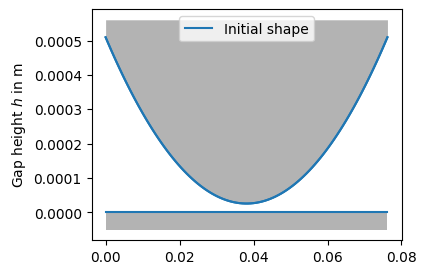

In [19]:
import matplotlib.pyplot as plt
import numpy as np

h = myProblem.topo.h_undeformed
h = h[:,0:1]
x = np.linspace(0, myProblem.grid['Lx'], h.shape[0])
h = h.ravel()
fig, ax = plt.subplots(1, 1, figsize=(4,3))

ax.plot(x, h, color='C0', label='Initial shape')
ax.set_ylabel('Gap height $h$ in m')
ax.fill_between(x, h, np.ones_like(x) * 1.1 * h.max(),
             color='0.7', lw=0.)
ax.fill_between(x, np.zeros_like(x), -np.ones_like(x) * 0.1 * h.max(),
             color='0.7', lw=0.)
ax.plot(x, h, color='C0')
ax.plot(x, np.zeros_like(h), color='C0')
ax.legend(loc='upper center')

plt.show()

Think about how there will be pressure building up on the left side of the slider and how the resulting deformation will change the shape.

Let's try it and plot the result:

-------------------------------------------------------------
Step   Timestep   Time       CFL        Residual  
-------------------------------------------------------------
0      1.9642e-07 0.0000e+00 4.5000e-01 1.0000e+00
1000   1.9439e-07 1.8967e-04 4.5000e-01 2.0626e-04
2000   1.7571e-07 3.8135e-04 4.5000e-01 1.1239e-03
3000   1.9145e-07 5.7260e-04 4.5000e-01 2.3597e-04
4000   1.9254e-07 7.6507e-04 4.5000e-01 1.6045e-04
5000   1.9267e-07 9.5770e-04 4.5000e-01 7.3573e-06
6000   1.9264e-07 1.1503e-03 4.5000e-01 1.4905e-05
7000   1.9264e-07 1.3430e-03 4.5000e-01 1.7148e-05
8000   1.9264e-07 1.5356e-03 4.5000e-01 1.4451e-05
9000   1.9264e-07 1.7283e-03 4.5000e-01 1.3207e-05
10000  1.9264e-07 1.9209e-03 4.5000e-01 1.1950e-05
11000  1.9264e-07 2.1135e-03 4.5000e-01 1.0653e-05
12000  1.9264e-07 2.3062e-03 4.5000e-01 9.3766e-06
13000  1.9264e-07 2.4988e-03 4.5000e-01 8.1216e-06
14000  1.9264e-07 2.6915e-03 4.5000e-01 6.8638e-06
15000  1.9264e-07 2.8841e-03 4.5000e-01 5.4649e-06
16000  1.

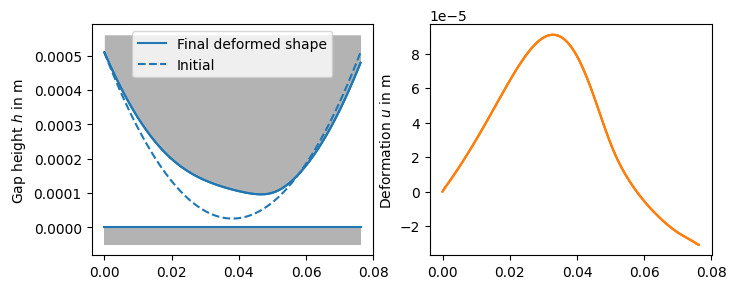

In [ ]:
# run the simulation
myProblem.run()

# plot the results
h0 = myProblem.topo.h_undeformed
h = myProblem.topo.h
u = myProblem.topo.deformation

fig, ax = plt.subplots(1, 2, figsize=(8,3))

h0 = h0[:,0:1]
h = h[:,0:1]
nx, ny = h.shape
x = np.linspace(0, myProblem.grid['Lx'], nx)
h = h.ravel()

ax[0].plot(x, h, color='C0', linestyle='-', label='Final deformed shape')
ax[0].plot(x, h0, color='C0', linestyle='--', label='Initial')
ax[0].set_ylabel('Gap height $h$ in m')
ax[0].fill_between(x, h, np.ones_like(x) * 1.1 * h.max(),
                color='0.7', lw=0.)
ax[0].fill_between(x, np.zeros_like(x), -np.ones_like(x) * 0.1 * h.max(),
                color='0.7', lw=0.)
ax[0].plot(x, h, color='C0')
ax[0].plot(x, np.zeros_like(h), color='C0')
ax[0].legend(loc='upper center')

ax[1].plot(x, u, color='C1')
ax[1].set_ylabel('Deformation $u$ in m')

plt.show()

Note here, as discussed in `Implementation Notes`, that at the left boundary, the deformed shape is fixed to the initial shape (meaning the effective deformation is set to zero here). With no fixing, the deformation would be positive for the whole domain and the whole slider would be pressed upwards.

### Journal Slider, Periodic